In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='micro')
    return score

def train_step(batch_item, training):
    data, label = batch_item

    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(data.to(device))
            loss = criterion(output, label.to(device))
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(data)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [3]:
# model
# 차원 축소된 데이터를 분류하기위해 
# 간단한 MLP 모델 구현 
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(784, 1000),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, 500),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 4)
        )

    def forward(self, x):
        output = self.network(x)
        return output

In [4]:
# 생성된 데이터
# 원래 훈련데이터 : 차원축소된 X_train 
# 결합하여 classification task 진행 

# 기존 차원 축소 데이터 로드
with open("./pca_data/pca_output.pickle", 'rb') as f:
    pca_output = pickle.load(f)
with open("./pca_data/pca_label.pickle", 'rb') as f:
    pca_label = pickle.load(f)

# 생성 데이터 
with open("./generated_data/generated_data.pickle", "rb") as f:
    generated_data = pickle.load(f)
with open("./generated_data/generated_label.pickle", "rb") as f:
    generated_label= pickle.load(f)

# 평가를 위한 테스트 데이터 : 차원축소된 X_test
with open("./pca_data/pca_output_test.pickle", 'rb') as f:
    pca_output_test = pickle.load(f)
with open("./pca_data/pca_label_test.pickle", 'rb') as f:
    pca_label_test = pickle.load(f)

In [5]:
label_decoder = {0: '3_00_0', 1: '3_a9_1', 2: '3_a9_2', 3: '3_a9_3'}
label_encoder = {'3_00_0': 0, '3_a9_1': 1, '3_a9_2': 2, '3_a9_3': 3}

device = ("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
class_n = len(label_encoder)
learning_rate = 0.00001
embedding_dim = 512
max_len = 24*6
dropout_rate = 0.1
epochs = 30
vision_pretrain = True

In [6]:
"""
차원 축소된 X_train, GAN을 통해 생성된 데이터 결합
GAN을 통한 데이터 어그멘테이션
"""
total_embedding = torch.cat((pca_output, generated_data), dim=0)
total_label = torch.cat((pca_label, generated_label), dim=0)
# 테스트 데이터 로드 
X_test = pca_output_test
y_test = pca_label_test

# 텐서 데이터셋 생성
train_dataset = torch.utils.data.TensorDataset(total_embedding, total_label)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

In [7]:
# 모델 생성 
model = MLP()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', verbose=True, patience=3, factor=0.5)

In [8]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))

    scheduler.step(total_loss/(batch+1))
    
    if np.max(metric_plot) == metric_plot[-1]:
        torch.save(model.state_dict(), f"./model_save/{model._get_name()}.pt")

13it [00:00, 25.37it/s, Epoch=1, Loss=1.248630, Mean Loss=1.280801, Mean F-1=0.788617]
13it [00:00, 94.32it/s, Epoch=2, Loss=1.186476, Mean Loss=1.220424, Mean F-1=0.792765]
13it [00:00, 90.08it/s, Epoch=3, Loss=1.157073, Mean Loss=1.159025, Mean F-1=0.812035]
13it [00:00, 104.19it/s, Epoch=4, Loss=1.045800, Mean Loss=1.095180, Mean F-1=0.822891]
13it [00:00, 97.33it/s, Epoch=5, Loss=0.979801, Mean Loss=1.029582, Mean F-1=0.839156]
13it [00:00, 97.51it/s, Epoch=6, Loss=0.895978, Mean Loss=0.962326, Mean F-1=0.846542]
13it [00:00, 98.08it/s, Epoch=7, Loss=0.829293, Mean Loss=0.896708, Mean F-1=0.860868]
13it [00:00, 93.23it/s, Epoch=8, Loss=0.823984, Mean Loss=0.830312, Mean F-1=0.868099]
13it [00:00, 89.97it/s, Epoch=9, Loss=0.834568, Mean Loss=0.771337, Mean F-1=0.871007]
13it [00:00, 108.13it/s, Epoch=10, Loss=0.671078, Mean Loss=0.717649, Mean F-1=0.878354]
13it [00:00, 100.98it/s, Epoch=11, Loss=0.644579, Mean Loss=0.671982, Mean F-1=0.879614]
13it [00:00, 103.04it/s, Epoch=12, Los

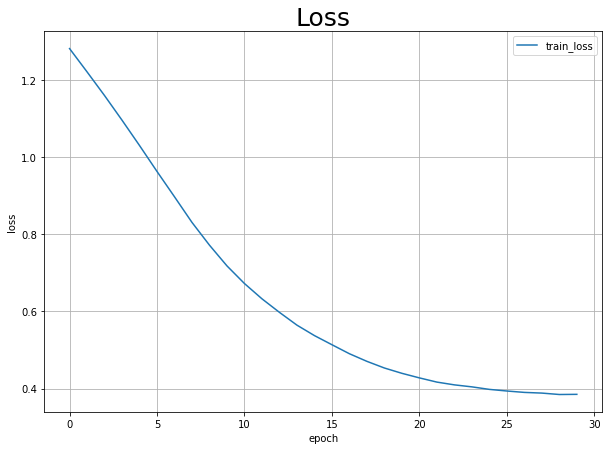

In [9]:
# 훈련과정 시각화
# Loss 그래프

plt.figure(figsize=(10,7))
plt.grid()
plt.plot(torch.Tensor(loss_plot).cpu(), label='train_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

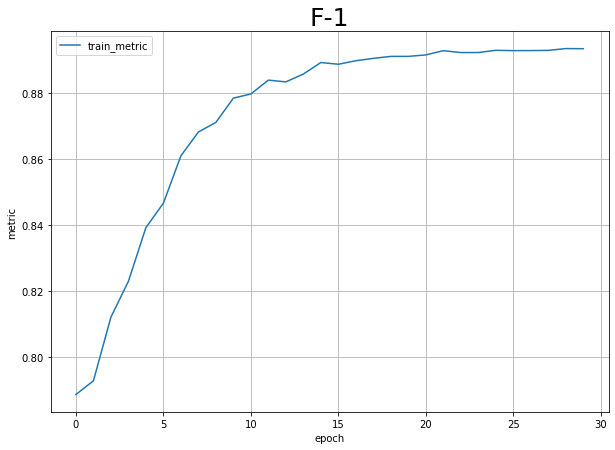

In [10]:
# 훈련과정 시각화
# F1 score 시각화

plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

In [11]:
# 모델 평가 
# 학습 잘된 모델 불러오기 
model = MLP()
model.load_state_dict(torch.load("./model_save/MLP.pt", map_location=device))
model.to(device)
model.eval()

total_test_acc = 0
total_test_precision = 0
total_test_recall = 0
total_test_f1 = 0

tqdm_dataset = tqdm(enumerate(test_dataloader))
for batch, batch_item in tqdm_dataset:
    data, label = batch_item
    
    with torch.no_grad():
        output = model(data.to(device))
        
    real = label.cpu()
    pred = torch.argmax(output, dim=1).cpu()

    test_accuracy = accuracy_score(real, pred)
    test_precision = precision_score(real, pred, average='micro')
    test_recall = recall_score(real, pred, average='micro')
    test_f_1 = f1_score(real, pred, average='micro')
    
    total_test_acc+=test_accuracy
    total_test_precision+=test_precision
    total_test_recall+=test_recall
    total_test_f1+=test_f_1
    
test_acc = total_test_acc/(batch+1)
test_precision = total_test_precision/(batch+1)
test_recall = total_test_recall/(batch+1)
test_f1 = total_test_f1/(batch+1)

result_dict = dict()

result_dict['accuracy'] = test_acc
result_dict['avg_recall'] = test_recall
result_dict['avg_precision'] = test_precision
result_dict['avg_f1_score'] = test_f1

test_log = " Total_Acc : {:0.4f} | Total_f1 : {:0.4f} | Total Precision & Recall : {:0.4f} & {:0.4f} ".format(test_acc, test_f1, test_precision, test_recall)
print(test_log)


3it [00:00, 34.75it/s]

 Total_Acc : 0.9212 | Total_f1 : 0.9212 | Total Precision & Recall : 0.9212 & 0.9212 
